
## Trabalho 1 

1. Para um distribuidor de encomendas o seu território está organizados em pontos (“nodes”) de fornecimento (“sources”), pontos de passagem  e pontos de entrega (“sinks”) ligados por vias de comunicação (“edges”) bidirecionais cada uma das quais associada uma capacidade em termos do número de veículos de transporte que suporta.
2. Os items distribuidos estão organizados em “pacotes” de três tipos “standard” : uma unidade, duas unidades e cinco unidades. Os pacotes são transportados em veículos todos com a capacidade de 10 unidades. Cada ponto de entrega tem um limite no número total de unidades que tem em “stock” e um limite no número de veículos que dispõe.
3. Cada encomenda é definida por o identificador do ponto de entrega e pelo número de pacotes, de cada um dos tipos, que devem ser entregues nesse ponto.
4. O objetivo do problema é decidir, a partir de uma encomenda e com um mínimo no número de veículos,



### - S = lista de sources (origens)
    # - T = lista de sinks (destinos)
    # - G = grafo com nós e arestas
    # - cap[(i,j)] = capacidade de cada aresta
    # - stock[s][k] = estoque de cada source por tipo de pacote
    # - demand[t][k] = demanda de cada sink por tipo de pacote
    # - veh_limit[t] = limite de veículos que cada sink pode receber
    # - package_types = {1:1, 2:2, 5:5} -> tipo de pacote : unidades
    # - C = capacidade de cada veículo (ex: 10 unidades)
        

        - em cada ponto de fornecimento,  se estará envolvido no fornecimento de unidades que essa encomenda requer sem violar os limites do seu “stock”.
        - em cada ponto de entrega,   como empacotar as unidades disponíveis, de acordo com a encomenda”,  e como as distribuir por veículos,
        - em cada veículo, qual o percurso a seguir até  ao ponto de entrega; para cada via ao longo de cada percurso, o total de veículos não pode exceder a capacidade dessa via.

In [17]:
import networkx as nx
from ortools.linear_solver import pywraplp
import math
# Criar instância do solver
solver = pywraplp.Solver.CreateSolver('SCIP')

Fazendo o grafo

{(1, 2): Text(0.7498821390176726, 0.6379521801622587, '2'),
 (1, 7): Text(0.934366938717206, 0.3513357430208006, '4'),
 (2, 3): Text(0.3057569138425884, 0.5777301696100914, '3'),
 (3, 4): Text(-0.23997067433959518, 0.48951657837132667, '1'),
 (3, 9): Text(0.09952789805024498, 0.06996836455253641, '2'),
 (4, 5): Text(-0.6093158166125886, 0.3168388739587924, '2'),
 (5, 6): Text(-0.8200342303846309, -0.10729001720592501, '3'),
 (5, 8): Text(-0.175025852131923, 0.08632756535208963, '1'),
 (6, 11): Text(-0.9796256822336173, -0.5542810297998517, '2'),
 (7, 8): Text(0.5859392950323499, 0.12603661766258223, '2'),
 (7, 12): Text(0.8617046372328847, -0.08475011194052451, '2'),
 (9, 10): Text(-0.21694835392973355, -0.5747481488737336, '1'),
 (9, 12): Text(0.47098243429144193, -0.3059189607340024, '1'),
 (10, 11): Text(-0.7467882725386541, -0.8402994705693739, '3')}

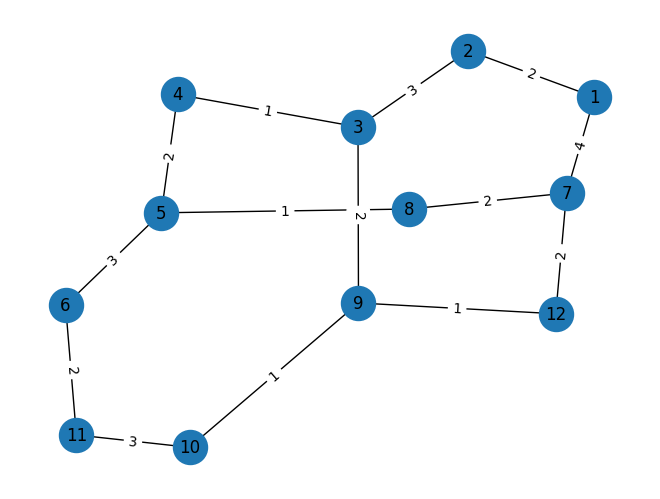

In [ ]:

G = nx.Graph()

# Nós
for i in range(1, 13):
    G.add_node(i)

# Arestas com pesos
edges = [
    (1,2,2), (2,3,3), (3,4,1), (4,5,2), (5,6,3),
    (1,7,4), (7,8,2), (8,5,1), (3,9,2), (9,10,1),
    (10,11,3), (11,6,2), (7,12,2), (12,9,1)
]
for a,b,w in edges:
    G.add_edge(a,b,weight=w)

# Tipos
G.nodes[1]['type'] = 'src'; G.nodes[1]['stock'] = (12,4,2) # SRC 1
G.nodes[7]['type'] = 'src'; G.nodes[7]['stock'] = (10,3,1) # SRC 7
G.nodes[6]['type'] = 'sink'; G.nodes[6]['demand'] = (15,5,2) #SINK 6

for n in range(2,13):
    if 'type' not in G.nodes[n]:
        G.nodes[n]['type'] = 'node'


pos = nx.spring_layout(G, seed=42)
edge_labels = nx.get_edge_attributes(G, "weight")

nx.draw(G, pos, with_labels=True, node_size=600, font_size=12)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)


# Problema

Temos uma rede de transporte representada por um grafo `G`:

- **Nós**: podem ser fornecedores (`src`), consumidor/sink (`sink`) ou nós intermediários (`node`).
- **Arestas**: representam estradas com capacidade limitada (`weight`), que define o número máximo de veículos que podem passar.
- **Veículos**: transportam três tipos de carga: S, M, L, com tamanhos diferentes (1, 2, 5 unidades por carga, respectivamente).

Objetivo:

- Atender a demanda do sink utilizando veículos provenientes dos fornecedores.
- Respeitar capacidades das estradas.
- Não ultrapassar os estoques dos fornecedores.
- Minimizar o número de veículos utilizados.

# Modelagem do Problema

1. **Variáveis:**

- `V[(node, carro)]`: se o veículo `carro` do fornecedor `node` está ativo (0 ou 1)
- `V_ocup[(node, carro)]`: carga do veículo em S, M e L
- `X[(a,b,node,carro)]`: se o veículo `carro` do fornecedor `node` percorre a estrada `(a,b)`

2. **Restrições principais:**

- Capacidade de cada veículo: `Vs + 2*Vm + 5*Vl <= c * V[(node, carro)]`
- Estoque do fornecedor: não enviar mais que disponível
- Demanda do sink: soma das cargas enviadas deve atender exatamente
- Capacidade das estradas: número de veículos que passam não pode ultrapassar o peso
- Fluxo contínuo: veículos só podem entrar e sair dos nós intermediários mantendo o fluxo
- Veículos só andam se estiverem ativos
- Caminhos coerentes: cada veículo só sai por um ponto de partida e entra por um ponto de chegada


*Neste caso o dicionario V_ocup foi escrito como O "ocupaçao para mais facil leitura*

### 1. Capacidade de cada veículo

$S_{v} + 2 M_{v} + 5 L_{v} \leq c \cdot V_{v}, \quad \forall v \in \text{veículos}$


### 2. Estoque máximo dos fornecedores

$\sum_{v \in V_{n}} O_{v,j} \leq \text{Stock}_{n,j}, \quad \forall n \in \text{fornecedores}, j \in \{S,M,L\}$



### 3. Preencher o sink

$\sum_{n \in \text{fornecedores}} \sum_{v \in V_n} O_{v,j} = D_{sink,j}, \quad j \in \{S,M,L\}$



### 4. Carros sem carga não podem andar

$X_{e,v} \leq V_v, \quad \forall e \in \text{arestas}, v \in \text{veículos}$



### 5. Capacidade máxima das arestas

$\sum_{v \in \text{veículos}} X_{e,v} \leq \text{cap}_e, \quad \forall e \in \text{arestas}$



### 6. Entradas no sink

$\sum_{e: \text{dest}(e) = \text{sink}} X_{e,v} \leq 1, \quad \forall v \in \text{veículos}$



### 7. Saídas do fornecedor

$\sum_{e: \text{orig}(e) = \text{src}} X_{e,v} \leq 1, \quad \forall v \in \text{veículos}$



### 8. Pelo menos o caminho mínimo

$\sum_{e \in \text{arestas}} X_{e,v} \geq \text{dist min}(\text{src}_v, \text{sink}_v) \cdot V_v$



### 9. Fluxo contínuo nos nós intermediários

$\sum_{e: \text{dest}(e) = n} X_{e,v} = \sum_{e: \text{orig}(e) = n} X_{e,v}, \quad \forall n \notin \{\text{src}_v, \text{sink}_v\}, \forall v$



A abordagem adotada consiste em identificar os veículos ativos capazes do sink e, em seguida, definir trajetórias coerentes para esses veículos, garantindo que todas as restrições do problema — como capacidade de carga, limites de estoque, capacidade das arestas e fluxo contínuo — sejam respeitadas.

In [ ]:
import math
from ortools.linear_solver import pywraplp


def routes(G, c):
    solver = pywraplp.Solver.CreateSolver("SCIP")

    V = dict()
    demand = dict()   # demanda por sink (x1,x2,x3)
    stock = dict()    # estoque por src (x1,x2,x3)
    cap = dict()      # capacidade das edges

       # 0. Capacidade de cada aresta
    for edge in G.edges:
        cap[edge] = G.edges[edge]["weight"]

    # 1. Extrai stocks e demandas dos nós
    for node in G.nodes:
        if G.nodes[node]["type"] == "src":
            (s, m, l) = G.nodes[node]["stock"]
            stock[node] = {
                "stock": (s, m, l),
                "V": math.ceil((s + 2*m + 5*l) / 10)
            }


    # 2. Extrai o sink que temos que resolver da encomenda
    for node in G.nodes:
        if G.nodes[node]["type"] == "sink":
            goal = node
            demand[node] = G.nodes[node]["demand"]
            break

    ##### VARIAVEIS SCIP #########

    # 3. Variáveis: se o veículo existe ou não
    for node in stock.keys():
        for carro in range(stock[node]["V"]):
            V[(node, carro)] = solver.IntVar(0, 1, f"V[{node}][{carro}]")

    # 4. Variáveis: ocupação de cada veículo (S, M, L)
    V_ocup = dict()
    for node in stock.keys():
        for carro in range(stock[node]["V"]):
            V_ocup[(node, carro)] = (
                solver.IntVar(0, 10, f"V[{node}][{carro}]S"),
                solver.IntVar(0, 5, f"V[{node}][{carro}]M"),
                solver.IntVar(0, 2, f"V[{node}][{carro}]L")
            )

    # 5. Variáveis: se um carro específico percorre uma edge
    X = dict()
    for (a, b) in G.edges:
        for (node, carro) in V.keys():
            X[(a, b, node, carro)] = solver.IntVar(0, 1, f"X[{(a,b,node,carro)}]")


################ RESTRIÇÕES #######################
   
    # 1. Restrição: capacidade de cada veículo (S=1, M=2, L=5) e de acordo com seu estado ativo ou nao
    for (node, carro), (Vs, Vm, Vl) in V_ocup.items():
        solver.Add(Vs + 2*Vm + 5*Vl <= c * V[(node, carro)])

    # 2. Restrição: não ultrapassar estoque dos src
    for node in stock.keys():
        for j in range(3):
            solver.Add( sum([V_ocup[(node, carro)][j] for carro in range(stock[node]["V"])]) <= stock[node]["stock"][j] )


    soma = list(map(sum,(zip(*[V_ocup[(node,carro)]for carro in range(stock[node]["V"]) for node in stock.keys() ])))) #somando todas variaveis pra dar certo

    # 3. Restrição: Preencher o sink:
    for j in range(3):
        solver.Add(soma[j] == demand[goal][j])

    # 4. Restrição: carros sem carga nao podem andar.
    for (a,b,src,carro), x in X.items():
        solver.Add(x <= V[(src,carro)])

    # 5. Restrição: os carros não podem ultrapassar o maximo de cap
    for (a, b) in G.edges:
        solver.Add(sum(X[a, b, src, carro] for (src, carro) in V.keys()) <= cap[(a, b)])

    # 6. Restrição: os carros nao podem entrar por mais de um sitio
    for src,carro in V.keys():
        solver.Add(sum([X[a,b,src,carro] for (a,b) in G.edges() if b == goal]) <= 1)

    # 7. Restrição: os carros so podem sair por um sitio
    for src,carro in V.keys():
        solver.Add(sum([X[a,b,src,carro] for (a,b) in G.edges() if a == src]) <= 1)

    # 8. Restrição: convem para cada carro ativo ele ande pelo menos o shortest path XD
    for src,carro in V.keys():
        solver.Add( sum([X[a,b,src,carro] for (a,b) in G.edges()]) >= nx.shortest_path_length(G,src,goal)*V[src,carro] )

    
    # 9. Restrição evitar que o carro vá para dois nós ao mesmo tempo...
    for src, carro in V.keys():
        for n in G.nodes:
            if n != src and n != goal:
                in_edges = [X[a,b,src,carro] for (a,b) in G.edges if b == n]
                out_edges = [X[a,b,src,carro] for (a,b) in G.edges if a == n]
                if in_edges and out_edges:
                    solver.Add(sum(in_edges) == sum(out_edges))



       

    ######## TRATAMENTO DE DADOS ########


    solver.Minimize(sum(list( V.values()) ))


    status = solver.Solve()
    
    if status == solver.OPTIMAL:

        print("=== Veículos usados ===")
        for (node, carro), var in V.items():
            if var.solution_value() > 0:
                carga = tuple(v.solution_value() for v in V_ocup[(node, carro)])
                print(f"Carro {carro} do node {node}: ativo, leva S={carga[0]}, M={carga[1]}, L={carga[2]}")
            
        print("\n=== Fluxo nas estradas ===")

        for (a,b,src,carro) in X.keys():
            if X[a,b,src,carro].solution_value() > 0:
                print(f"{a}->{b} de {src}. carro{carro} :: {X[a,b,src,carro].solution_value()}")
        
        print("\n=== Demanda ===")
        for node, d in demand.items():
            print(f"Sink {node} demanda {d}")
            
       

        print("\n=== Caminhos dos carros ===")
        for (src, carro), var in V.items():
            if var.solution_value() > 0.5:
                caminho = [a for (a,b,s,c) in X.keys() if s==src and c==carro and X[a,b,s,c].solution_value()>0.5]
                if caminho:
                    # adiciona o último nó (goal)
                    caminho.append([b for (a,b,s,c) in X.keys() if s==src and c==carro and X[a,b,s,c].solution_value()>0.5 and b not in caminho][0])
                    # converte tudo para string antes de imprimir
                    caminho_str = [str(n) for n in caminho]
                    print(f"Carro {carro} de {src}: {' → '.join(caminho_str)}")


                
        print("\n=== Estoques ===")
        for node, s in stock.items():
            print(f"Src {node} estoque {s['stock']}")
    else:
        print("Nenhuma solução encontrada.")

    
c = 10
routes(G,c)

=== Veículos usados ===
Carro 1 do node 1: ativo, leva S=0.0, M=2.0, L=1.0
Carro 2 do node 1: ativo, leva S=5.0, M=2.0, L=0.0
Carro 0 do node 7: ativo, leva S=10.0, M=0.0, L=0.0
Carro 2 do node 7: ativo, leva S=0.0, M=1.0, L=1.0

=== Fluxo nas estradas ===
1->2 de 1. carro1 :: 1.0
1->2 de 1. carro2 :: 1.0
1->7 de 7. carro0 :: 1.0
1->7 de 7. carro2 :: 1.0
2->3 de 1. carro1 :: 1.0
2->3 de 1. carro2 :: 1.0
3->4 de 1. carro2 :: 1.0
3->9 de 1. carro1 :: 1.0
4->5 de 1. carro2 :: 1.0
5->8 de 1. carro2 :: 1.0
6->11 de 7. carro0 :: 1.0
6->11 de 7. carro2 :: 1.0
7->8 de 7. carro2 :: 1.0
7->12 de 7. carro0 :: 1.0
9->10 de 1. carro1 :: 1.0
10->11 de 1. carro1 :: 1.0

=== Demanda ===
Sink 6 demanda (15, 5, 2)

=== Caminhos dos carros ===
Carro 1 de 1: 1 → 2 → 3 → 9 → 10 → 11
Carro 2 de 1: 1 → 2 → 3 → 4 → 5 → 8
Carro 0 de 7: 1 → 6 → 7 → 11
Carro 2 de 7: 1 → 6 → 7 → 11

=== Estoques ===
Src 1 estoque (12, 4, 2)
Src 7 estoque (10, 3, 1)
